In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import torch
import torchvision.models as models
from torchvision import transforms
from efficientnet_pytorch import EfficientNet

from preprocess import *
from dataset import TrainDataset, TestDataset
from train import Trainer
from network import Network
from inference import inference, validate

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')

INPUT_DIR = os.path.join('/opt/ml', 'input', 'data')
TRAIN_DIR = os.path.join(INPUT_DIR, 'train')

In [11]:
PROCESS = False

if not PROCESS:
    df_train_mask = pd.read_csv(os.path.join(TRAIN_DIR, 'train_processed_mask_v4.csv'))
    df_valid_mask = pd.read_csv(os.path.join(TRAIN_DIR, 'valid_processed_mask_v4.csv'))
    df_train_ag = pd.read_csv(os.path.join(TRAIN_DIR, 'train_processed_ag_v4.csv'))
    df_valid_ag = pd.read_csv(os.path.join(TRAIN_DIR, 'valid_processed_ag_v4.csv'))
else:
    df = pd.read_csv(os.path.join(TRAIN_DIR, 'train.csv'))
    df_train_mask, df_valid_mask = preprocess(df)
    df_train_ag, df_valid_ag = preprocess_v2(df)
    df_train_mask.to_csv(os.path.join(TRAIN_DIR, 'train_processed_mask_v4.csv'), index=False)
    df_valid_mask.to_csv(os.path.join(TRAIN_DIR, 'valid_processed_mask_v4.csv'), index=False)
    df_train_ag.to_csv(os.path.join(TRAIN_DIR, 'train_processed_ag_v4.csv'), index=False)
    df_valid_ag.to_csv(os.path.join(TRAIN_DIR, 'valid_processed_ag_v4.csv'), index=False)

In [12]:
df = pd.read_csv(os.path.join(TRAIN_DIR, 'train.csv'))

In [13]:
df

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59
...,...,...,...,...,...
2695,006954,male,Asian,19,006954_male_Asian_19
2696,006955,male,Asian,19,006955_male_Asian_19
2697,006956,male,Asian,19,006956_male_Asian_19
2698,006957,male,Asian,20,006957_male_Asian_20


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


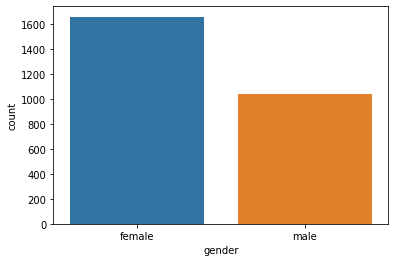

In [20]:
sns.countplot(df.gender)

In [38]:
pd.concat([df_train_ag, df_valid_ag]).age.apply(lambda x: 0 if x < 30 else(1 if 30<=x<60 else 2))

0       0
1       0
2       0
3       0
4       0
       ..
2837    1
2838    1
2839    1
2840    1
2841    1
Name: age, Length: 18914, dtype: int64

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<Figure size 1224x288 with 0 Axes>

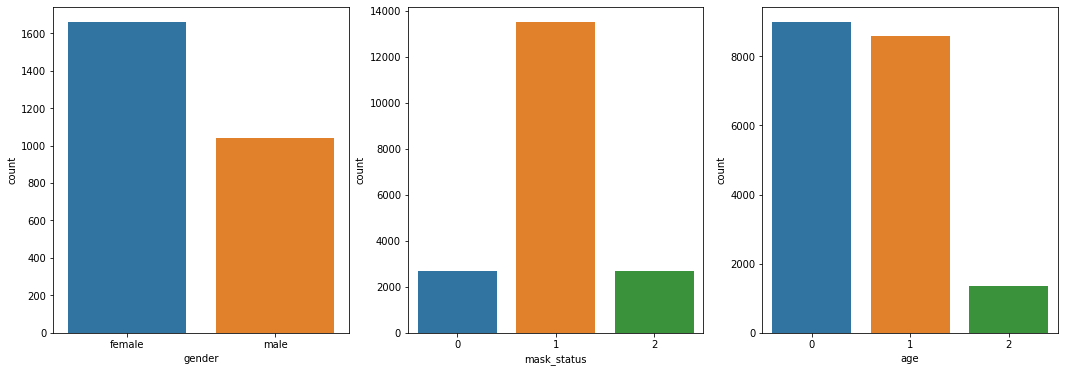

In [39]:
plt.figure(figsize=(17, 4))
fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(18,6)
sns.countplot(df.gender, ax=axes[0])
sns.countplot(pd.concat([df_train_ag, df_valid_ag]).mask_status, ax=axes[1])
sns.countplot(pd.concat([df_train_ag, df_valid_ag]).age.apply(lambda x: 0 if x < 30 else(1 if 30<=x<60 else 2)))
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


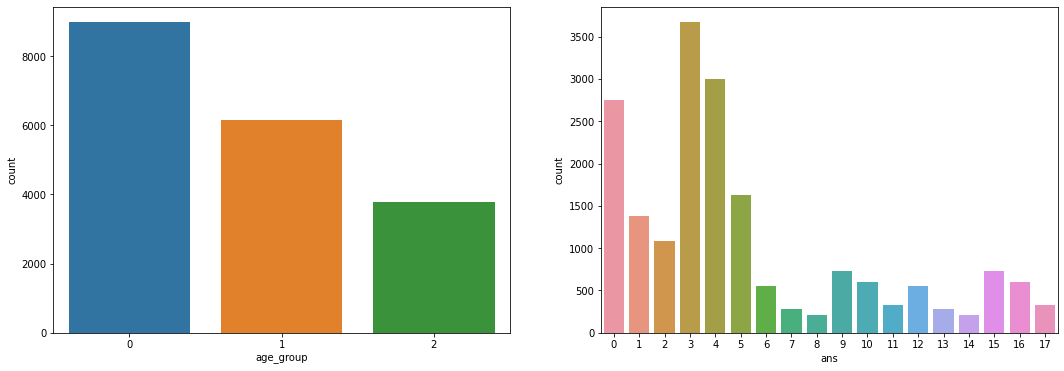

In [44]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(18,6)
sns.countplot(pd.concat([df_train_ag, df_valid_ag]).age_group, ax=axes[0])
sns.countplot(pd.concat([df_train_ag, df_valid_ag]).ans, ax=axes[1])

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


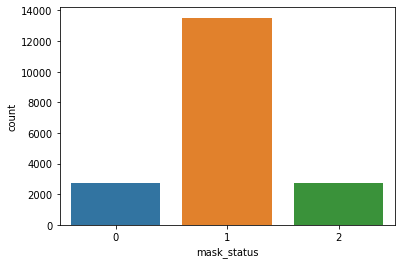

In [22]:
sns.countplot(pd.concat([df_train_ag, df_valid_ag]).mask_status)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


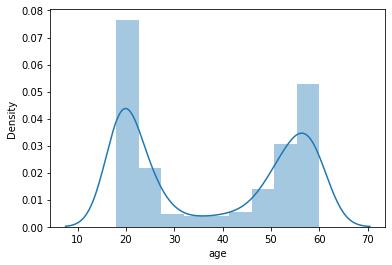

In [5]:
import seaborn as sns

sns.distplot(df['age'])

In [3]:
transform = transforms.Compose([
                transforms.CenterCrop(350),
                transforms.Resize((224, 224)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomChoice([
                    transforms.RandomAffine(degrees=3),
                    transforms.ColorJitter(0.1, 0.1, 0.1, 0),
                        ]),
                transforms.ToTensor(),
                transforms.Normalize((0.548, 0.504, 0.479), (0.237, 0.247, 0.246)),
])

In [4]:
# Efficient Net

# Hyper params
BS = 128
LR = 3e-4
EPOCHS = 200

# Backbones
efficientnet_1 = EfficientNet.from_pretrained("efficientnet-b3", num_classes=3) # mask
efficientnet_2 = EfficientNet.from_pretrained("efficientnet-b3", num_classes=2) # gender
efficientnet_3 = EfficientNet.from_pretrained("efficientnet-b3", num_classes=3) # age
efficientnet_4 = EfficientNet.from_pretrained("efficientnet-b3", num_classes=18) # all

# Models
model_mask_ef = Trainer(efficientnet_1, df_train_mask, df_valid_mask, 'mask', transform, BS, LR, EPOCHS, use_optimizer=0, use_scheduler=3)
model_gender_ef = Trainer(efficientnet_2, df_train_ag, df_valid_ag, 'gender', transform, BS, LR, EPOCHS, use_optimizer=0, use_scheduler=3)
model_age_ef = Trainer(efficientnet_3, df_train_ag, df_valid_ag, 'age', transform, BS, LR, EPOCHS, use_optimizer=0, use_scheduler=3)
model_all_ef = Trainer(efficientnet_4, df_train_ag, df_valid_ag, 'all', transform, BS, LR, EPOCHS, use_optimizer=0, use_scheduler=3)

Loaded pretrained weights for efficientnet-b3
Loaded pretrained weights for efficientnet-b3
Loaded pretrained weights for efficientnet-b3
Loaded pretrained weights for efficientnet-b3


In [5]:
model_all_ef.train()

Running on device: cuda:0 start training...
Setting - Epochs: 200, Learning rate: 0.0003 


  0%|          | 0/126 [00:00<?, ?batch/s]

Validation loss decreased (inf --> 1.953097).  Saving model ...


Epoch 2: 100%|██████████| 126/126 [02:24<00:00,  1.14s/batch, accuracy=59.7, current_lr=1e-5, loss=1.52, val_acc=60.7, val_loss=1.37]


Validation loss decreased (1.953097 --> 1.369793).  Saving model ...


Epoch 3: 100%|██████████| 126/126 [02:36<00:00,  1.24s/batch, accuracy=65.3, current_lr=1e-5, loss=1.14, val_acc=67.9, val_loss=1.08]


Validation loss decreased (1.369793 --> 1.078346).  Saving model ...


Epoch 4: 100%|██████████| 126/126 [02:32<00:00,  1.21s/batch, accuracy=70.8, current_lr=1e-5, loss=0.945, val_acc=72.1, val_loss=0.895]


Validation loss decreased (1.078346 --> 0.895136).  Saving model ...


Epoch 5: 100%|██████████| 126/126 [02:33<00:00,  1.22s/batch, accuracy=73.6, current_lr=1e-5, loss=0.806, val_acc=73.5, val_loss=0.783]


Validation loss decreased (0.895136 --> 0.783342).  Saving model ...


Epoch 6: 100%|██████████| 126/126 [02:31<00:00,  1.20s/batch, accuracy=72.2, current_lr=1e-5, loss=0.711, val_acc=76.3, val_loss=0.697]


Validation loss decreased (0.783342 --> 0.696531).  Saving model ...


Epoch 7: 100%|██████████| 126/126 [02:29<00:00,  1.19s/batch, accuracy=77.8, current_lr=1e-5, loss=0.614, val_acc=77.2, val_loss=0.648]


Validation loss decreased (0.696531 --> 0.647657).  Saving model ...


Epoch 8: 100%|██████████| 126/126 [02:34<00:00,  1.23s/batch, accuracy=79.2, current_lr=1e-5, loss=0.573, val_acc=78, val_loss=0.597] 


Validation loss decreased (0.647657 --> 0.596941).  Saving model ...


Epoch 9: 100%|██████████| 126/126 [02:36<00:00,  1.24s/batch, accuracy=80.6, current_lr=1e-5, loss=0.541, val_acc=78.8, val_loss=0.563]


Validation loss decreased (0.596941 --> 0.563462).  Saving model ...


Epoch 10: 100%|██████████| 126/126 [02:35<00:00,  1.23s/batch, accuracy=84.7, current_lr=1e-5, loss=0.442, val_acc=78.5, val_loss=0.548]


Validation loss decreased (0.563462 --> 0.548154).  Saving model ...


Epoch 11: 100%|██████████| 126/126 [02:35<00:00,  1.23s/batch, accuracy=80.6, current_lr=1e-5, loss=0.443, val_acc=79.5, val_loss=0.531]


Validation loss decreased (0.548154 --> 0.530568).  Saving model ...


Epoch 12: 100%|██████████| 126/126 [02:34<00:00,  1.23s/batch, accuracy=79.2, current_lr=1e-5, loss=0.431, val_acc=79.5, val_loss=0.516]


Validation loss decreased (0.530568 --> 0.516455).  Saving model ...


Epoch 13: 100%|██████████| 126/126 [02:35<00:00,  1.23s/batch, accuracy=79.2, current_lr=1e-5, loss=0.459, val_acc=79.7, val_loss=0.502]


Validation loss decreased (0.516455 --> 0.502120).  Saving model ...


Epoch 14: 100%|██████████| 126/126 [02:33<00:00,  1.22s/batch, accuracy=83.3, current_lr=1e-5, loss=0.379, val_acc=79.8, val_loss=0.5] 


Validation loss decreased (0.502120 --> 0.499810).  Saving model ...


  0%|          | 0/126 [00:00<?, ?batch/s]

EarlyStopping counter: 1 out of 10


  0%|          | 0/126 [00:00<?, ?batch/s]

EarlyStopping counter: 2 out of 10


  0%|          | 0/126 [00:00<?, ?batch/s]

EarlyStopping counter: 3 out of 10


  0%|          | 0/126 [00:00<?, ?batch/s]

EarlyStopping counter: 4 out of 10


  0%|          | 0/126 [00:00<?, ?batch/s]

EarlyStopping counter: 5 out of 10


  0%|          | 0/126 [00:00<?, ?batch/s]

EarlyStopping counter: 6 out of 10


  0%|          | 0/126 [00:00<?, ?batch/s]

EarlyStopping counter: 7 out of 10


  0%|          | 0/126 [00:00<?, ?batch/s]

EarlyStopping counter: 8 out of 10


  0%|          | 0/126 [00:00<?, ?batch/s]

EarlyStopping counter: 9 out of 10


Epoch 24: 100%|██████████| 126/126 [02:33<00:00,  1.22s/batch, accuracy=93.1, current_lr=1e-5, loss=0.217, val_acc=79.1, val_loss=0.567]


EarlyStopping counter: 10 out of 10
Early stopping


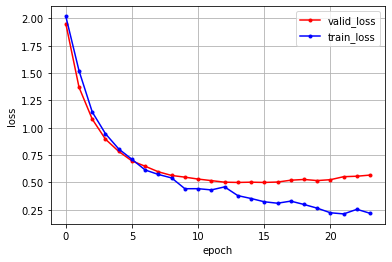

In [9]:
model_all_ef.show_history()

In [7]:
model_all_ef.show_report()

100%|██████████| 23/23 [00:23<00:00,  1.03s/it]

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       410
           1       0.60      0.71      0.65       210
           2       0.64      0.46      0.54       160
           3       0.97      0.96      0.96       555
           4       0.69      0.84      0.76       450
           5       0.64      0.36      0.46       245
           6       0.91      0.99      0.95        82
           7       0.53      0.50      0.51        42
           8       0.54      0.41      0.46        32
           9       0.95      0.96      0.96       111
          10       0.73      0.91      0.81        90
          11       0.95      0.41      0.57        49
          12       0.91      0.98      0.94        82
          13       0.67      0.62      0.64        42
          14       0.70      0.72      0.71        32
          15       0.96      0.95      0.96       111
          16       0.67      0.87      0.75        90
          17       0.67    

In [8]:
inference({'all_model': [model_all_ef.model]}, False)

100%|██████████| 99/99 [01:20<00:00,  1.23it/s]


,Unnamed: 0,ImageID,ans
0,0,cbc5c6e168e63498590db46022617123f1fe1268.jpg,14
1,1,0e72482bf56b3581c081f7da2a6180b8792c7089.jpg,2
2,2,b549040c49190cedc41327748aeb197c1670f14d.jpg,14
3,3,4f9cb2a045c6d5b9e50ad3459ea7b791eb6e18bc.jpg,13
4,4,248428d9a4a5b6229a7081c32851b90cb8d38d0c.jpg,12
...,...,...,...
12595,12595,d71d4570505d6af8f777690e63edfa8d85ea4476.jpg,2
12596,12596,6cf1300e8e218716728d5820c0bab553306c2cfd.jpg,5
12597,12597,8140edbba31c3a824e817e6d5fb95343199e2387.jpg,9
12598,12598,030d439efe6fb5a7bafda45a393fc19f2bf57f54.jpg,1


In [5]:
model_mask_ef.train()

Running on device: cuda:0 start training...
Setting - Epochs: 200, Learning rate: 0.0003 


  0%|          | 0/54 [00:00<?, ?batch/s]

Validation loss decreased (inf --> 0.367419).  Saving model ...


Epoch 2: 100%|██████████| 54/54 [00:59<00:00,  1.11s/batch, accuracy=96, current_lr=1e-5, loss=0.234, val_acc=95.8, val_loss=0.184] 


Validation loss decreased (0.367419 --> 0.183921).  Saving model ...


Epoch 3: 100%|██████████| 54/54 [00:59<00:00,  1.10s/batch, accuracy=97, current_lr=1e-5, loss=0.161, val_acc=97.2, val_loss=0.1]   


Validation loss decreased (0.183921 --> 0.100185).  Saving model ...


Epoch 4: 100%|██████████| 54/54 [01:00<00:00,  1.11s/batch, accuracy=97, current_lr=1e-5, loss=0.109, val_acc=98.4, val_loss=0.0653] 


Validation loss decreased (0.100185 --> 0.065311).  Saving model ...


Epoch 5: 100%|██████████| 54/54 [01:00<00:00,  1.11s/batch, accuracy=98, current_lr=1e-5, loss=0.0664, val_acc=98.8, val_loss=0.0515]


Validation loss decreased (0.065311 --> 0.051528).  Saving model ...


Epoch 6: 100%|██████████| 54/54 [01:00<00:00,  1.12s/batch, accuracy=99, current_lr=1e-5, loss=0.0476, val_acc=98.9, val_loss=0.0329]


Validation loss decreased (0.051528 --> 0.032916).  Saving model ...


Epoch 7: 100%|██████████| 54/54 [01:00<00:00,  1.12s/batch, accuracy=99, current_lr=1e-5, loss=0.0367, val_acc=99.4, val_loss=0.0305]


Validation loss decreased (0.032916 --> 0.030525).  Saving model ...


Epoch 8: 100%|██████████| 54/54 [01:00<00:00,  1.11s/batch, accuracy=100, current_lr=1e-5, loss=0.0306, val_acc=99.7, val_loss=0.0191]


Validation loss decreased (0.030525 --> 0.019053).  Saving model ...


Epoch 9: 100%|██████████| 54/54 [01:02<00:00,  1.16s/batch, accuracy=100, current_lr=1e-5, loss=0.0264, val_acc=99.5, val_loss=0.0182]


Validation loss decreased (0.019053 --> 0.018245).  Saving model ...


  0%|          | 0/54 [00:00<?, ?batch/s]

EarlyStopping counter: 1 out of 10


Epoch 11: 100%|██████████| 54/54 [01:00<00:00,  1.11s/batch, accuracy=100, current_lr=1e-5, loss=0.0116, val_acc=99.6, val_loss=0.0173]


Validation loss decreased (0.018245 --> 0.017261).  Saving model ...


Epoch 12: 100%|██████████| 54/54 [01:00<00:00,  1.11s/batch, accuracy=100, current_lr=1e-5, loss=0.00955, val_acc=99.6, val_loss=0.0137]


Validation loss decreased (0.017261 --> 0.013708).  Saving model ...


  0%|          | 0/54 [00:00<?, ?batch/s]

EarlyStopping counter: 1 out of 10


Epoch 14: 100%|██████████| 54/54 [01:00<00:00,  1.11s/batch, accuracy=100, current_lr=1e-5, loss=0.00681, val_acc=99.7, val_loss=0.0116]


Validation loss decreased (0.013708 --> 0.011618).  Saving model ...


  0%|          | 0/54 [00:00<?, ?batch/s]

EarlyStopping counter: 1 out of 10


Epoch 16: 100%|██████████| 54/54 [01:00<00:00,  1.11s/batch, accuracy=100, current_lr=1e-5, loss=0.00502, val_acc=99.7, val_loss=0.0105]


Validation loss decreased (0.011618 --> 0.010486).  Saving model ...


  0%|          | 0/54 [00:00<?, ?batch/s]

EarlyStopping counter: 1 out of 10


  0%|          | 0/54 [00:00<?, ?batch/s]

EarlyStopping counter: 2 out of 10


  0%|          | 0/54 [00:00<?, ?batch/s]

EarlyStopping counter: 3 out of 10


  0%|          | 0/54 [00:00<?, ?batch/s]

EarlyStopping counter: 4 out of 10


Epoch 21: 100%|██████████| 54/54 [01:00<00:00,  1.12s/batch, accuracy=100, current_lr=1e-5, loss=0.00469, val_acc=99.8, val_loss=0.00997]


Validation loss decreased (0.010486 --> 0.009971).  Saving model ...


Epoch 22: 100%|██████████| 54/54 [01:00<00:00,  1.12s/batch, accuracy=100, current_lr=1e-5, loss=0.00402, val_acc=99.8, val_loss=0.00901]


Validation loss decreased (0.009971 --> 0.009014).  Saving model ...


  0%|          | 0/54 [00:00<?, ?batch/s]

EarlyStopping counter: 1 out of 10


  0%|          | 0/54 [00:00<?, ?batch/s]

EarlyStopping counter: 2 out of 10


Epoch 25: 100%|██████████| 54/54 [01:00<00:00,  1.12s/batch, accuracy=100, current_lr=1e-5, loss=0.00301, val_acc=99.8, val_loss=0.00863]


Validation loss decreased (0.009014 --> 0.008631).  Saving model ...


Epoch 26: 100%|██████████| 54/54 [01:00<00:00,  1.12s/batch, accuracy=100, current_lr=1e-5, loss=0.00534, val_acc=99.9, val_loss=0.00654]


Validation loss decreased (0.008631 --> 0.006543).  Saving model ...


  0%|          | 0/54 [00:00<?, ?batch/s]

EarlyStopping counter: 1 out of 10


  0%|          | 0/54 [00:00<?, ?batch/s]

EarlyStopping counter: 2 out of 10


  0%|          | 0/54 [00:00<?, ?batch/s]

EarlyStopping counter: 3 out of 10


  0%|          | 0/54 [00:00<?, ?batch/s]

EarlyStopping counter: 4 out of 10


  0%|          | 0/54 [00:00<?, ?batch/s]

EarlyStopping counter: 5 out of 10


  0%|          | 0/54 [00:00<?, ?batch/s]

EarlyStopping counter: 6 out of 10


  0%|          | 0/54 [00:00<?, ?batch/s]

EarlyStopping counter: 7 out of 10


  0%|          | 0/54 [00:00<?, ?batch/s]

EarlyStopping counter: 8 out of 10


  0%|          | 0/54 [00:00<?, ?batch/s]

EarlyStopping counter: 9 out of 10


Epoch 36: 100%|██████████| 54/54 [01:00<00:00,  1.12s/batch, accuracy=100, current_lr=1e-5, loss=0.00123, val_acc=99.7, val_loss=0.0108]


EarlyStopping counter: 10 out of 10
Early stopping


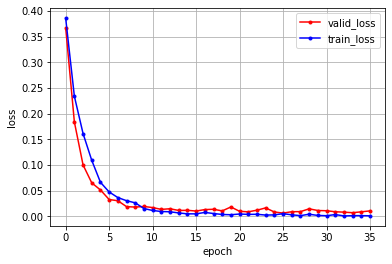

In [8]:
model_mask_ef.show_history()

In [9]:
model_mask_ef.show_report()

100%|██████████| 10/10 [00:09<00:00,  1.09it/s]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       405
           1       1.00      1.00      1.00       405
           2       1.00      1.00      1.00       405

    accuracy                           1.00      1215
   macro avg       1.00      1.00      1.00      1215
weighted avg       1.00      1.00      1.00      1215



In [10]:
model_age_ef.train()

  0%|          | 0/126 [00:00<?, ?batch/s]

Running on device: cuda:0 start training...
Setting - Epochs: 200, Learning rate: 0.0003 


  0%|          | 0/126 [00:00<?, ?batch/s]

Validation loss decreased (inf --> 0.681547).  Saving model ...


Epoch 2: 100%|██████████| 126/126 [02:17<00:00,  1.09s/batch, accuracy=72.2, current_lr=1e-5, loss=0.548, val_acc=78.6, val_loss=0.468]


Validation loss decreased (0.681547 --> 0.468447).  Saving model ...


Epoch 3: 100%|██████████| 126/126 [02:17<00:00,  1.09s/batch, accuracy=76.4, current_lr=1e-5, loss=0.473, val_acc=79.9, val_loss=0.426]


Validation loss decreased (0.468447 --> 0.426277).  Saving model ...


Epoch 4: 100%|██████████| 126/126 [02:16<00:00,  1.09s/batch, accuracy=76.4, current_lr=1e-5, loss=0.426, val_acc=80.3, val_loss=0.407]


Validation loss decreased (0.426277 --> 0.406870).  Saving model ...


Epoch 5: 100%|██████████| 126/126 [02:16<00:00,  1.08s/batch, accuracy=80.6, current_lr=1e-5, loss=0.41, val_acc=80.5, val_loss=0.397]


Validation loss decreased (0.406870 --> 0.397237).  Saving model ...


Epoch 6: 100%|██████████| 126/126 [02:17<00:00,  1.09s/batch, accuracy=77.8, current_lr=1e-5, loss=0.382, val_acc=80.7, val_loss=0.396]


Validation loss decreased (0.397237 --> 0.395678).  Saving model ...


  0%|          | 0/126 [00:00<?, ?batch/s]

EarlyStopping counter: 1 out of 10


  0%|          | 0/126 [00:00<?, ?batch/s]

EarlyStopping counter: 2 out of 10


  0%|          | 0/126 [00:00<?, ?batch/s]

EarlyStopping counter: 3 out of 10


  0%|          | 0/126 [00:00<?, ?batch/s]

EarlyStopping counter: 4 out of 10


  0%|          | 0/126 [00:00<?, ?batch/s]

EarlyStopping counter: 5 out of 10


  0%|          | 0/126 [00:00<?, ?batch/s]

EarlyStopping counter: 6 out of 10


  0%|          | 0/126 [00:00<?, ?batch/s]

EarlyStopping counter: 7 out of 10


  0%|          | 0/126 [00:00<?, ?batch/s]

EarlyStopping counter: 8 out of 10


  0%|          | 0/126 [00:00<?, ?batch/s]

EarlyStopping counter: 9 out of 10


Epoch 16: 100%|██████████| 126/126 [02:17<00:00,  1.09s/batch, accuracy=94.4, current_lr=1e-5, loss=0.134, val_acc=80.4, val_loss=0.471]


EarlyStopping counter: 10 out of 10
Early stopping


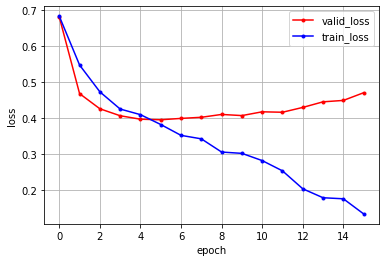

In [11]:
model_age_ef.show_history()

In [12]:
model_age_ef.show_report()

100%|██████████| 23/23 [00:20<00:00,  1.10it/s]

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1351
           1       0.67      0.81      0.74       924
           2       0.67      0.40      0.50       567

    accuracy                           0.81      2842
   macro avg       0.77      0.73      0.73      2842
weighted avg       0.81      0.81      0.80      2842



In [13]:
model_gender_ef.train()

  0%|          | 0/126 [00:00<?, ?batch/s]

Running on device: cuda:0 start training...
Setting - Epochs: 200, Learning rate: 0.0003 


  0%|          | 0/126 [00:00<?, ?batch/s]

Validation loss decreased (inf --> 0.171291).  Saving model ...


Epoch 2: 100%|██████████| 126/126 [02:17<00:00,  1.09s/batch, accuracy=93.1, current_lr=1e-5, loss=0.162, val_acc=95.6, val_loss=0.126]


Validation loss decreased (0.171291 --> 0.125804).  Saving model ...


Epoch 3: 100%|██████████| 126/126 [02:17<00:00,  1.09s/batch, accuracy=97.2, current_lr=1e-5, loss=0.134, val_acc=96, val_loss=0.115]  


Validation loss decreased (0.125804 --> 0.114773).  Saving model ...


Epoch 4: 100%|██████████| 126/126 [02:17<00:00,  1.09s/batch, accuracy=100, current_lr=1e-5, loss=0.0626, val_acc=96.9, val_loss=0.0957]


Validation loss decreased (0.114773 --> 0.095737).  Saving model ...


Epoch 5: 100%|██████████| 126/126 [02:16<00:00,  1.08s/batch, accuracy=98.6, current_lr=1e-5, loss=0.0717, val_acc=96.5, val_loss=0.0949]


Validation loss decreased (0.095737 --> 0.094895).  Saving model ...


Epoch 6: 100%|██████████| 126/126 [02:16<00:00,  1.08s/batch, accuracy=100, current_lr=1e-5, loss=0.0471, val_acc=96.9, val_loss=0.0891]


Validation loss decreased (0.094895 --> 0.089069).  Saving model ...


  0%|          | 0/126 [00:00<?, ?batch/s]

EarlyStopping counter: 1 out of 10


Epoch 8: 100%|██████████| 126/126 [02:15<00:00,  1.08s/batch, accuracy=98.6, current_lr=1e-5, loss=0.028, val_acc=97.1, val_loss=0.0825]


Validation loss decreased (0.089069 --> 0.082530).  Saving model ...


  0%|          | 0/126 [00:00<?, ?batch/s]

EarlyStopping counter: 1 out of 10


Epoch 10: 100%|██████████| 126/126 [02:24<00:00,  1.15s/batch, accuracy=100, current_lr=1e-5, loss=0.0269, val_acc=97.2, val_loss=0.082]


Validation loss decreased (0.082530 --> 0.082015).  Saving model ...


  0%|          | 0/126 [00:00<?, ?batch/s]

EarlyStopping counter: 1 out of 10


  0%|          | 0/126 [00:00<?, ?batch/s]

EarlyStopping counter: 2 out of 10


  0%|          | 0/126 [00:00<?, ?batch/s]

EarlyStopping counter: 3 out of 10


  0%|          | 0/126 [00:00<?, ?batch/s]

EarlyStopping counter: 4 out of 10


  0%|          | 0/126 [00:00<?, ?batch/s]

EarlyStopping counter: 5 out of 10


  0%|          | 0/126 [00:00<?, ?batch/s]

EarlyStopping counter: 6 out of 10


  0%|          | 0/126 [00:00<?, ?batch/s]

EarlyStopping counter: 7 out of 10


  0%|          | 0/126 [00:00<?, ?batch/s]

EarlyStopping counter: 8 out of 10


  0%|          | 0/126 [00:00<?, ?batch/s]

EarlyStopping counter: 9 out of 10


Epoch 20: 100%|██████████| 126/126 [02:31<00:00,  1.20s/batch, accuracy=100, current_lr=1e-5, loss=0.00639, val_acc=97.4, val_loss=0.0918]


EarlyStopping counter: 10 out of 10
Early stopping


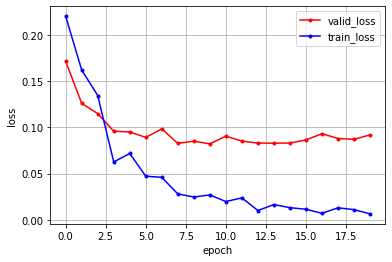

In [14]:
model_gender_ef.show_history()

In [15]:
model_gender_ef.show_report()

100%|██████████| 23/23 [00:22<00:00,  1.00it/s]

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1750
           1       0.95      0.98      0.96      1092

    accuracy                           0.97      2842
   macro avg       0.96      0.97      0.97      2842
weighted avg       0.97      0.97      0.97      2842



In [17]:
inference({'mask_model': [model_mask_ef.model],
           'gender_model': [model_gender_ef.model],
           'age_model': [model_age_ef.model]}, True)

100%|██████████| 99/99 [01:13<00:00,  1.35it/s]


,Unnamed: 0,ImageID,ans,mask,gender,age,class
0,0,cbc5c6e168e63498590db46022617123f1fe1268.jpg,14,0,1,2,012
1,1,0e72482bf56b3581c081f7da2a6180b8792c7089.jpg,2,1,1,2,112
2,2,b549040c49190cedc41327748aeb197c1670f14d.jpg,14,0,1,2,012
3,3,4f9cb2a045c6d5b9e50ad3459ea7b791eb6e18bc.jpg,14,0,1,2,012
4,4,248428d9a4a5b6229a7081c32851b90cb8d38d0c.jpg,12,0,1,0,010
...,...,...,...,...,...,...,...
12595,12595,d71d4570505d6af8f777690e63edfa8d85ea4476.jpg,2,1,1,2,112
12596,12596,6cf1300e8e218716728d5820c0bab553306c2cfd.jpg,5,1,0,2,102
12597,12597,8140edbba31c3a824e817e6d5fb95343199e2387.jpg,9,2,0,0,200
12598,12598,030d439efe6fb5a7bafda45a393fc19f2bf57f54.jpg,1,1,1,1,111


In [16]:
validate(df_valid_ag, 
         {'mask_model': [model_mask_ef.model],
          'gender_model': [model_gender_ef.model],
          'age_model': [model_age_ef.model]}, True)

100%|██████████| 23/23 [00:17<00:00,  1.30it/s]


              precision    recall  f1-score   support

           0       0.92      0.96      0.94       410
           1       0.57      0.67      0.62       210
           2       0.61      0.49      0.54       160
           3       0.95      0.96      0.95       555
           4       0.68      0.82      0.74       450
           5       0.62      0.30      0.41       245
           6       0.91      0.95      0.93        82
           7       0.60      0.67      0.63        42
           8       0.56      0.47      0.51        32
           9       0.93      0.95      0.94       111
          10       0.72      0.83      0.77        90
          11       0.72      0.43      0.54        49
          12       0.92      0.94      0.93        82
          13       0.52      0.60      0.56        42
          14       0.57      0.50      0.53        32
          15       0.93      0.96      0.95       111
          16       0.70      0.79      0.74        90
          17       0.70    

,id,path,mask_status,gender,race,age,age_group,ans,mask_pred,gender_pred,age_group_pred,ans_pred
0,001700,001700_male_Asian_33/mask5.jpg,1,1,Asian,33,1,1,1,0,1,4
1,001700,001700_male_Asian_33/incorrect_mask.jpg,2,1,Asian,33,1,7,2,0,1,10
2,001700,001700_male_Asian_33/mask1.jpg,1,1,Asian,33,1,1,1,0,0,3
3,001700,001700_male_Asian_33/mask3.jpg,1,1,Asian,33,1,1,1,0,1,4
4,001700,001700_male_Asian_33/normal.jpg,0,1,Asian,33,1,13,0,0,1,16
...,...,...,...,...,...,...,...,...,...,...,...,...
2837,005558,005558_male_Asian_52/mask1.jpg,1,1,Asian,52,1,1,1,1,1,1
2838,005558,005558_male_Asian_52/mask4.jpg,1,1,Asian,52,1,1,1,1,1,1
2839,005558,005558_male_Asian_52/mask2.jpg,1,1,Asian,52,1,1,1,1,1,1
2840,005558,005558_male_Asian_52/mask5.jpg,1,1,Asian,52,1,1,1,1,1,1


In [18]:
# DenseNet

BS = 128
LR = 3e-4
EPOCHS = 200

# Backbones
densenet_1 = models.densenet121(pretrained=True)
densenet_2 = models.densenet121(pretrained=True)
densenet_3 = models.densenet121(pretrained=True)

densenet_mask = Network(densenet_1, out_features=3)
densenet_gender = Network(densenet_2, out_features=2)
densenet_age = Network(densenet_3, out_features=3)

model_mask_ds = Trainer(densenet_mask, df_train_mask, df_valid_mask, 'mask', transform, BS, LR, EPOCHS, use_optimizer=0, use_scheduler=3)
model_gender_ds = Trainer(densenet_gender, df_train_ag, df_valid_ag, 'gender', transform, BS, LR, EPOCHS, use_optimizer=0, use_scheduler=3)
model_age_ds = Trainer(densenet_age, df_train_ag, df_valid_ag, 'age', transform, BS, LR, EPOCHS, use_optimizer=0, use_scheduler=3)

In [19]:
model_age_ds.train()

  0%|          | 0/126 [00:00<?, ?batch/s]

Running on device: cuda:0 start training...
Setting - Epochs: 200, Learning rate: 0.0003 


  0%|          | 0/126 [00:00<?, ?batch/s]

Validation loss decreased (inf --> 0.488891).  Saving model ...


  0%|          | 0/126 [00:00<?, ?batch/s]

Validation loss decreased (0.488891 --> 0.448162).  Saving model ...


  0%|          | 0/126 [00:00<?, ?batch/s]

Validation loss decreased (0.448162 --> 0.428640).  Saving model ...


  0%|          | 0/126 [00:00<?, ?batch/s]

EarlyStopping counter: 1 out of 10


  0%|          | 0/126 [00:00<?, ?batch/s]

EarlyStopping counter: 2 out of 10


  0%|          | 0/126 [00:00<?, ?batch/s]

EarlyStopping counter: 3 out of 10


  0%|          | 0/126 [00:00<?, ?batch/s]

EarlyStopping counter: 4 out of 10


  0%|          | 0/126 [00:00<?, ?batch/s]

EarlyStopping counter: 5 out of 10


  0%|          | 0/126 [00:00<?, ?batch/s]

EarlyStopping counter: 6 out of 10


  0%|          | 0/126 [00:00<?, ?batch/s]

EarlyStopping counter: 7 out of 10


  0%|          | 0/126 [00:00<?, ?batch/s]

EarlyStopping counter: 8 out of 10


  0%|          | 0/126 [00:00<?, ?batch/s]

EarlyStopping counter: 9 out of 10


Epoch 13: 100%|██████████| 126/126 [02:22<00:00,  1.13s/batch, accuracy=98.6, current_lr=1e-5, loss=0.0406, val_acc=80.5, val_loss=0.566]


EarlyStopping counter: 10 out of 10
Early stopping


In [20]:
model_mask_ds.train()

Running on device: cuda:0 start training...
Setting - Epochs: 200, Learning rate: 0.0003 


  0%|          | 0/54 [00:00<?, ?batch/s]

Validation loss decreased (inf --> 0.029433).  Saving model ...


  0%|          | 0/54 [00:00<?, ?batch/s]

Validation loss decreased (0.029433 --> 0.025633).  Saving model ...


  0%|          | 0/54 [00:00<?, ?batch/s]

Validation loss decreased (0.025633 --> 0.016915).  Saving model ...


  0%|          | 0/54 [00:00<?, ?batch/s]

EarlyStopping counter: 1 out of 10


  0%|          | 0/54 [00:00<?, ?batch/s]

Validation loss decreased (0.016915 --> 0.015719).  Saving model ...


  0%|          | 0/54 [00:00<?, ?batch/s]

EarlyStopping counter: 1 out of 10


  0%|          | 0/54 [00:00<?, ?batch/s]

Validation loss decreased (0.015719 --> 0.012106).  Saving model ...


  0%|          | 0/54 [00:00<?, ?batch/s]

EarlyStopping counter: 1 out of 10


  0%|          | 0/54 [00:00<?, ?batch/s]

Validation loss decreased (0.012106 --> 0.008292).  Saving model ...


  0%|          | 0/54 [00:00<?, ?batch/s]

EarlyStopping counter: 1 out of 10


  0%|          | 0/54 [00:00<?, ?batch/s]

EarlyStopping counter: 2 out of 10


  0%|          | 0/54 [00:00<?, ?batch/s]

EarlyStopping counter: 3 out of 10


  0%|          | 0/54 [00:00<?, ?batch/s]

EarlyStopping counter: 4 out of 10


  0%|          | 0/54 [00:00<?, ?batch/s]

EarlyStopping counter: 5 out of 10


  0%|          | 0/54 [00:00<?, ?batch/s]

EarlyStopping counter: 6 out of 10


  0%|          | 0/54 [00:00<?, ?batch/s]

EarlyStopping counter: 7 out of 10


  0%|          | 0/54 [00:00<?, ?batch/s]

EarlyStopping counter: 8 out of 10


  0%|          | 0/54 [00:00<?, ?batch/s]

EarlyStopping counter: 9 out of 10


Epoch 19: 100%|██████████| 54/54 [01:05<00:00,  1.22s/batch, accuracy=100, current_lr=1e-5, loss=0.000125, val_acc=99.7, val_loss=0.0156]


EarlyStopping counter: 10 out of 10
Early stopping


In [21]:
model_gender_ds.train()

Running on device: cuda:0 start training...
Setting - Epochs: 200, Learning rate: 0.0003 


  0%|          | 0/126 [00:00<?, ?batch/s]

Validation loss decreased (inf --> 0.138443).  Saving model ...


  0%|          | 0/126 [00:00<?, ?batch/s]

Validation loss decreased (0.138443 --> 0.111200).  Saving model ...


  0%|          | 0/126 [00:00<?, ?batch/s]

Validation loss decreased (0.111200 --> 0.107870).  Saving model ...


  0%|          | 0/126 [00:00<?, ?batch/s]

Validation loss decreased (0.107870 --> 0.106244).  Saving model ...


  0%|          | 0/126 [00:00<?, ?batch/s]

Validation loss decreased (0.106244 --> 0.105970).  Saving model ...


  0%|          | 0/126 [00:00<?, ?batch/s]

EarlyStopping counter: 1 out of 10


  0%|          | 0/126 [00:00<?, ?batch/s]

Validation loss decreased (0.105970 --> 0.100001).  Saving model ...


  0%|          | 0/126 [00:00<?, ?batch/s]

EarlyStopping counter: 1 out of 10


  0%|          | 0/126 [00:00<?, ?batch/s]

EarlyStopping counter: 2 out of 10


  0%|          | 0/126 [00:00<?, ?batch/s]

EarlyStopping counter: 3 out of 10


  0%|          | 0/126 [00:00<?, ?batch/s]

EarlyStopping counter: 4 out of 10


  0%|          | 0/126 [00:00<?, ?batch/s]

EarlyStopping counter: 5 out of 10


  0%|          | 0/126 [00:00<?, ?batch/s]

EarlyStopping counter: 6 out of 10


  0%|          | 0/126 [00:00<?, ?batch/s]

EarlyStopping counter: 7 out of 10


  0%|          | 0/126 [00:00<?, ?batch/s]

EarlyStopping counter: 8 out of 10


  0%|          | 0/126 [00:00<?, ?batch/s]

EarlyStopping counter: 9 out of 10


Epoch 17: 100%|██████████| 126/126 [02:17<00:00,  1.09s/batch, accuracy=100, current_lr=1e-5, loss=0.000337, val_acc=97.5, val_loss=0.112]


EarlyStopping counter: 10 out of 10
Early stopping


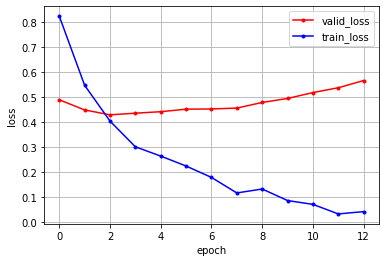

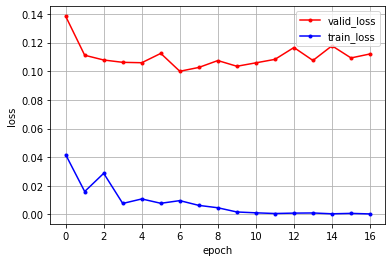

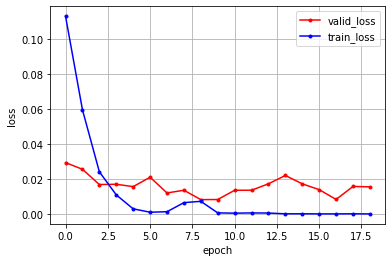

In [22]:
model_age_ds.show_history()
model_gender_ds.show_history()
model_mask_ds.show_history()

In [23]:
inference({'mask_model': [model_mask_ds.model],
           'gender_model': [model_gender_ds.model],
           'age_model': [model_age_ds.model]}, True)

100%|██████████| 99/99 [01:13<00:00,  1.35it/s]


,Unnamed: 0,ImageID,ans,mask,gender,age,class
0,0,cbc5c6e168e63498590db46022617123f1fe1268.jpg,13,0,1,1,011
1,1,0e72482bf56b3581c081f7da2a6180b8792c7089.jpg,2,1,1,2,112
2,2,b549040c49190cedc41327748aeb197c1670f14d.jpg,14,0,1,2,012
3,3,4f9cb2a045c6d5b9e50ad3459ea7b791eb6e18bc.jpg,14,0,1,2,012
4,4,248428d9a4a5b6229a7081c32851b90cb8d38d0c.jpg,12,0,1,0,010
...,...,...,...,...,...,...,...
12595,12595,d71d4570505d6af8f777690e63edfa8d85ea4476.jpg,2,1,1,2,112
12596,12596,6cf1300e8e218716728d5820c0bab553306c2cfd.jpg,5,1,0,2,102
12597,12597,8140edbba31c3a824e817e6d5fb95343199e2387.jpg,9,2,0,0,200
12598,12598,030d439efe6fb5a7bafda45a393fc19f2bf57f54.jpg,1,1,1,1,111


In [24]:
validate(df_valid_ag, 
         {'mask_model': [model_mask_ds.model],
          'gender_model': [model_gender_ds.model],
          'age_model': [model_age_ds.model]}, True)

100%|██████████| 23/23 [00:17<00:00,  1.33it/s]

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       410
           1       0.58      0.57      0.58       210
           2       0.55      0.60      0.57       160
           3       0.94      0.95      0.94       555
           4       0.74      0.68      0.71       450
           5       0.55      0.56      0.56       245
           6       0.93      0.94      0.93        82
           7       0.61      0.52      0.56        42
           8       0.51      0.59      0.55        32
           9       0.91      0.96      0.94       111
          10       0.76      0.71      0.74        90
          11       0.60      0.61      0.61        49
          12       0.93      0.91      0.92        82
          13       0.59      0.64      0.61        42
          14       0.52      0.50      0.51        32
          15       0.93      0.96      0.95       111
          16       0.76      0.77      0.76        90
          17       0.64    

,id,path,mask_status,gender,race,age,age_group,ans,mask_pred,gender_pred,age_group_pred,ans_pred
0,001700,001700_male_Asian_33/mask5.jpg,1,1,Asian,33,1,1,1,0,1,4
1,001700,001700_male_Asian_33/incorrect_mask.jpg,2,1,Asian,33,1,7,2,0,0,9
2,001700,001700_male_Asian_33/mask1.jpg,1,1,Asian,33,1,1,1,0,2,5
3,001700,001700_male_Asian_33/mask3.jpg,1,1,Asian,33,1,1,1,0,1,4
4,001700,001700_male_Asian_33/normal.jpg,0,1,Asian,33,1,13,0,0,1,16
...,...,...,...,...,...,...,...,...,...,...,...,...
2837,005558,005558_male_Asian_52/mask1.jpg,1,1,Asian,52,1,1,1,1,1,1
2838,005558,005558_male_Asian_52/mask4.jpg,1,1,Asian,52,1,1,1,1,1,1
2839,005558,005558_male_Asian_52/mask2.jpg,1,1,Asian,52,1,1,1,1,1,1
2840,005558,005558_male_Asian_52/mask5.jpg,1,1,Asian,52,1,1,1,1,1,1


In [25]:
inference({'mask_model': [model_mask_ef.model],
           'gender_model': [model_gender_ef.model],
           'age_model': [model_age_ds.model]}, True)

100%|██████████| 99/99 [01:15<00:00,  1.31it/s]


,Unnamed: 0,ImageID,ans,mask,gender,age,class
0,0,cbc5c6e168e63498590db46022617123f1fe1268.jpg,13,0,1,1,011
1,1,0e72482bf56b3581c081f7da2a6180b8792c7089.jpg,2,1,1,2,112
2,2,b549040c49190cedc41327748aeb197c1670f14d.jpg,14,0,1,2,012
3,3,4f9cb2a045c6d5b9e50ad3459ea7b791eb6e18bc.jpg,14,0,1,2,012
4,4,248428d9a4a5b6229a7081c32851b90cb8d38d0c.jpg,12,0,1,0,010
...,...,...,...,...,...,...,...
12595,12595,d71d4570505d6af8f777690e63edfa8d85ea4476.jpg,2,1,1,2,112
12596,12596,6cf1300e8e218716728d5820c0bab553306c2cfd.jpg,5,1,0,2,102
12597,12597,8140edbba31c3a824e817e6d5fb95343199e2387.jpg,9,2,0,0,200
12598,12598,030d439efe6fb5a7bafda45a393fc19f2bf57f54.jpg,1,1,1,1,111


In [26]:
validate(df_valid_ag, 
         {'mask_model': [model_mask_ef.model],
          'gender_model': [model_gender_ef.model],
          'age_model': [model_age_ds.model]}, True)

100%|██████████| 23/23 [00:17<00:00,  1.32it/s]

              precision    recall  f1-score   support

           0       0.91      0.96      0.93       410
           1       0.60      0.57      0.59       210
           2       0.57      0.61      0.59       160
           3       0.95      0.95      0.95       555
           4       0.75      0.69      0.72       450
           5       0.57      0.59      0.58       245
           6       0.90      0.95      0.92        82
           7       0.61      0.52      0.56        42
           8       0.51      0.59      0.55        32
           9       0.93      0.95      0.94       111
          10       0.77      0.71      0.74        90
          11       0.62      0.63      0.63        49
          12       0.93      0.91      0.92        82
          13       0.55      0.64      0.59        42
          14       0.53      0.50      0.52        32
          15       0.93      0.96      0.95       111
          16       0.76      0.74      0.75        90
          17       0.65    

,id,path,mask_status,gender,race,age,age_group,ans,mask_pred,gender_pred,age_group_pred,ans_pred
0,001700,001700_male_Asian_33/mask5.jpg,1,1,Asian,33,1,1,1,0,1,4
1,001700,001700_male_Asian_33/incorrect_mask.jpg,2,1,Asian,33,1,7,2,0,0,9
2,001700,001700_male_Asian_33/mask1.jpg,1,1,Asian,33,1,1,1,0,2,5
3,001700,001700_male_Asian_33/mask3.jpg,1,1,Asian,33,1,1,1,0,1,4
4,001700,001700_male_Asian_33/normal.jpg,0,1,Asian,33,1,13,0,0,1,16
...,...,...,...,...,...,...,...,...,...,...,...,...
2837,005558,005558_male_Asian_52/mask1.jpg,1,1,Asian,52,1,1,1,1,1,1
2838,005558,005558_male_Asian_52/mask4.jpg,1,1,Asian,52,1,1,1,1,1,1
2839,005558,005558_male_Asian_52/mask2.jpg,1,1,Asian,52,1,1,1,1,1,1
2840,005558,005558_male_Asian_52/mask5.jpg,1,1,Asian,52,1,1,1,1,1,1


In [27]:
inference({'mask_model': [model_mask_ef.model, model_mask_ds.model],
           'gender_model': [model_gender_ef.model, model_gender_ds.model],
           'age_model': [model_age_ef.model, model_age_ds.model]}, True)

100%|██████████| 99/99 [01:18<00:00,  1.26it/s]


,Unnamed: 0,ImageID,ans,mask,gender,age,class
0,0,cbc5c6e168e63498590db46022617123f1fe1268.jpg,13,0,1,1,011
1,1,0e72482bf56b3581c081f7da2a6180b8792c7089.jpg,2,1,1,2,112
2,2,b549040c49190cedc41327748aeb197c1670f14d.jpg,14,0,1,2,012
3,3,4f9cb2a045c6d5b9e50ad3459ea7b791eb6e18bc.jpg,14,0,1,2,012
4,4,248428d9a4a5b6229a7081c32851b90cb8d38d0c.jpg,12,0,1,0,010
...,...,...,...,...,...,...,...
12595,12595,d71d4570505d6af8f777690e63edfa8d85ea4476.jpg,2,1,1,2,112
12596,12596,6cf1300e8e218716728d5820c0bab553306c2cfd.jpg,5,1,0,2,102
12597,12597,8140edbba31c3a824e817e6d5fb95343199e2387.jpg,9,2,0,0,200
12598,12598,030d439efe6fb5a7bafda45a393fc19f2bf57f54.jpg,1,1,1,1,111


In [28]:
validate(df_valid_ag, 
         {'mask_model': [model_mask_ef.model, model_mask_ds.model],
          'gender_model': [model_gender_ef.model, model_gender_ds.model],
          'age_model': [model_age_ef.model, model_age_ds.model]}, True)

100%|██████████| 23/23 [00:18<00:00,  1.25it/s]

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       410
           1       0.59      0.63      0.61       210
           2       0.59      0.56      0.57       160
           3       0.95      0.96      0.95       555
           4       0.74      0.78      0.76       450
           5       0.65      0.50      0.57       245
           6       0.92      0.94      0.93        82
           7       0.63      0.62      0.63        42
           8       0.58      0.59      0.58        32
           9       0.92      0.95      0.94       111
          10       0.76      0.80      0.78        90
          11       0.68      0.53      0.60        49
          12       0.93      0.95      0.94        82
          13       0.57      0.62      0.59        42
          14       0.52      0.47      0.49        32
          15       0.93      0.96      0.95       111
          16       0.78      0.81      0.79        90
          17       0.74    

,id,path,mask_status,gender,race,age,age_group,ans,mask_pred,gender_pred,age_group_pred,ans_pred
0,001700,001700_male_Asian_33/mask5.jpg,1,1,Asian,33,1,1,1,0,1,4
1,001700,001700_male_Asian_33/incorrect_mask.jpg,2,1,Asian,33,1,7,2,0,1,10
2,001700,001700_male_Asian_33/mask1.jpg,1,1,Asian,33,1,1,1,0,0,3
3,001700,001700_male_Asian_33/mask3.jpg,1,1,Asian,33,1,1,1,0,1,4
4,001700,001700_male_Asian_33/normal.jpg,0,1,Asian,33,1,13,0,0,1,16
...,...,...,...,...,...,...,...,...,...,...,...,...
2837,005558,005558_male_Asian_52/mask1.jpg,1,1,Asian,52,1,1,1,1,1,1
2838,005558,005558_male_Asian_52/mask4.jpg,1,1,Asian,52,1,1,1,1,1,1
2839,005558,005558_male_Asian_52/mask2.jpg,1,1,Asian,52,1,1,1,1,1,1
2840,005558,005558_male_Asian_52/mask5.jpg,1,1,Asian,52,1,1,1,1,1,1


In [55]:
model_age_ef.show_report()

100%|██████████| 23/23 [00:20<00:00,  1.10it/s]

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1351
           1       0.77      0.59      0.67       924
           2       0.56      0.72      0.63       567

    accuracy                           0.81      2842
   macro avg       0.76      0.77      0.76      2842
weighted avg       0.81      0.81      0.80      2842



In [29]:
os.rename('checkpoint_age.pt', '0406_9_dense_checkpoint_age.pt')
os.rename('checkpoint_mask.pt', '0406_9_dense_checkpoint_mask.pt')
os.rename('checkpoint_gender.pt', '0406_9_dense_checkpoint_gender.pt')

In [30]:
# resnext50

BS = 128
LR = 3e-4
EPOCHS = 200

# Backbones
resnext_1 = models.resnext50_32x4d(pretrained=True)
resnext_2 = models.resnext50_32x4d(pretrained=True)
resnext_3 = models.resnext50_32x4d(pretrained=True)
resnext_4 = models.resnext50_32x4d(pretrained=True)

resnext_mask = Network(resnext_1, out_features=3)
resnext_gender = Network(resnext_2, out_features=2)
resnext_age = Network(resnext_3, out_features=3)
resnext_all = Network(resnext_4, out_features=18)

model_mask_rn = Trainer(resnext_mask, df_train_mask, df_valid_mask, 'mask', transform, BS, LR, EPOCHS, use_optimizer=0, use_scheduler=3)
model_gender_rn = Trainer(resnext_gender, df_train_ag, df_valid_ag, 'gender', transform, BS, LR, EPOCHS, use_optimizer=0, use_scheduler=3)
model_age_rn = Trainer(resnext_age, df_train_ag, df_valid_ag, 'age', transform, BS, LR, EPOCHS, use_optimizer=0, use_scheduler=3)
model_all_rn = Trainer(resnext_all, df_train_ag, df_valid_ag, 'all', transform, BS, LR, EPOCHS, use_optimizer=0, use_scheduler=3)

In [31]:
model_age_rn.train()

  0%|          | 0/126 [00:00<?, ?batch/s]

Running on device: cuda:0 start training...
Setting - Epochs: 200, Learning rate: 0.0003 


Epoch 1: 100%|██████████| 126/126 [02:18<00:00,  1.10s/batch, accuracy=76.4, current_lr=1e-5, loss=0.543, val_acc=83.1, val_loss=0.373]


Validation loss decreased (inf --> 0.372559).  Saving model ...


Epoch 2: 100%|██████████| 126/126 [02:20<00:00,  1.12s/batch, accuracy=76.4, current_lr=1e-5, loss=0.48, val_acc=83.6, val_loss=0.36] 


Validation loss decreased (0.372559 --> 0.360012).  Saving model ...


Epoch 3: 100%|██████████| 126/126 [02:19<00:00,  1.10s/batch, accuracy=79.2, current_lr=1e-5, loss=0.4, val_acc=83.9, val_loss=0.357] 


Validation loss decreased (0.360012 --> 0.357328).  Saving model ...


  0%|          | 0/126 [00:00<?, ?batch/s]

EarlyStopping counter: 1 out of 10


  0%|          | 0/126 [00:00<?, ?batch/s]

EarlyStopping counter: 2 out of 10


  0%|          | 0/126 [00:00<?, ?batch/s]

EarlyStopping counter: 3 out of 10


  0%|          | 0/126 [00:00<?, ?batch/s]

EarlyStopping counter: 4 out of 10


  0%|          | 0/126 [00:00<?, ?batch/s]

EarlyStopping counter: 5 out of 10


  0%|          | 0/126 [00:00<?, ?batch/s]

EarlyStopping counter: 6 out of 10


  0%|          | 0/126 [00:00<?, ?batch/s]

EarlyStopping counter: 7 out of 10


  0%|          | 0/126 [00:00<?, ?batch/s]

EarlyStopping counter: 8 out of 10


  0%|          | 0/126 [00:00<?, ?batch/s]

EarlyStopping counter: 9 out of 10


Epoch 13: 100%|██████████| 126/126 [02:24<00:00,  1.15s/batch, accuracy=100, current_lr=1e-5, loss=0.00621, val_acc=83.1, val_loss=0.787]

EarlyStopping counter: 10 out of 10
Early stopping


In [32]:
model_gender_rn.train()

  0%|          | 0/126 [00:00<?, ?batch/s]

Running on device: cuda:0 start training...
Setting - Epochs: 200, Learning rate: 0.0003 


Epoch 1: 100%|██████████| 126/126 [02:25<00:00,  1.15s/batch, accuracy=91.7, current_lr=1e-5, loss=0.14, val_acc=97.7, val_loss=0.0958]


Validation loss decreased (inf --> 0.095807).  Saving model ...


Epoch 2: 100%|██████████| 126/126 [02:25<00:00,  1.15s/batch, accuracy=98.6, current_lr=1e-5, loss=0.066, val_acc=97.9, val_loss=0.0776]


Validation loss decreased (0.095807 --> 0.077566).  Saving model ...


Epoch 3: 100%|██████████| 126/126 [02:24<00:00,  1.15s/batch, accuracy=100, current_lr=1e-5, loss=0.0218, val_acc=97.8, val_loss=0.0723]


Validation loss decreased (0.077566 --> 0.072348).  Saving model ...


  0%|          | 0/126 [00:00<?, ?batch/s]

EarlyStopping counter: 1 out of 10


  0%|          | 0/126 [00:00<?, ?batch/s]

EarlyStopping counter: 2 out of 10


  0%|          | 0/126 [00:00<?, ?batch/s]

EarlyStopping counter: 3 out of 10


  0%|          | 0/126 [00:00<?, ?batch/s]

EarlyStopping counter: 4 out of 10


  0%|          | 0/126 [00:00<?, ?batch/s]

EarlyStopping counter: 5 out of 10


  0%|          | 0/126 [00:00<?, ?batch/s]

EarlyStopping counter: 6 out of 10


  0%|          | 0/126 [00:00<?, ?batch/s]

EarlyStopping counter: 7 out of 10


  0%|          | 0/126 [00:00<?, ?batch/s]

EarlyStopping counter: 8 out of 10


  0%|          | 0/126 [00:00<?, ?batch/s]

EarlyStopping counter: 9 out of 10


Epoch 13: 100%|██████████| 126/126 [02:21<00:00,  1.13s/batch, accuracy=100, current_lr=1e-5, loss=0.00147, val_acc=97.9, val_loss=0.0891]

EarlyStopping counter: 10 out of 10
Early stopping


In [33]:
model_mask_rn.train()

  0%|          | 0/54 [00:00<?, ?batch/s]

Running on device: cuda:0 start training...
Setting - Epochs: 200, Learning rate: 0.0003 


Epoch 1: 100%|██████████| 54/54 [01:02<00:00,  1.15s/batch, accuracy=99, current_lr=1e-5, loss=0.0221, val_acc=99.8, val_loss=0.0148] 


Validation loss decreased (inf --> 0.014780).  Saving model ...


Epoch 2: 100%|██████████| 54/54 [01:01<00:00,  1.14s/batch, accuracy=100, current_lr=1e-5, loss=0.00423, val_acc=99.7, val_loss=0.0146]


Validation loss decreased (0.014780 --> 0.014608).  Saving model ...


Epoch 3: 100%|██████████| 54/54 [01:02<00:00,  1.15s/batch, accuracy=100, current_lr=1e-5, loss=0.00293, val_acc=99.8, val_loss=0.00987]


Validation loss decreased (0.014608 --> 0.009865).  Saving model ...


Epoch 4: 100%|██████████| 54/54 [01:02<00:00,  1.15s/batch, accuracy=100, current_lr=1e-5, loss=0.00338, val_acc=99.8, val_loss=0.00978]


Validation loss decreased (0.009865 --> 0.009782).  Saving model ...


  0%|          | 0/54 [00:00<?, ?batch/s]

EarlyStopping counter: 1 out of 10


  0%|          | 0/54 [00:00<?, ?batch/s]

EarlyStopping counter: 2 out of 10


Epoch 7: 100%|██████████| 54/54 [01:00<00:00,  1.12s/batch, accuracy=100, current_lr=1e-5, loss=0.000952, val_acc=99.8, val_loss=0.00968]


Validation loss decreased (0.009782 --> 0.009679).  Saving model ...


  0%|          | 0/54 [00:00<?, ?batch/s]

EarlyStopping counter: 1 out of 10


Epoch 9: 100%|██████████| 54/54 [01:00<00:00,  1.13s/batch, accuracy=100, current_lr=1e-5, loss=0.000667, val_acc=99.9, val_loss=0.00777]


Validation loss decreased (0.009679 --> 0.007765).  Saving model ...


  0%|          | 0/54 [00:00<?, ?batch/s]

EarlyStopping counter: 1 out of 10


  0%|          | 0/54 [00:00<?, ?batch/s]

EarlyStopping counter: 2 out of 10


  0%|          | 0/54 [00:00<?, ?batch/s]

EarlyStopping counter: 3 out of 10


  0%|          | 0/54 [00:00<?, ?batch/s]

EarlyStopping counter: 6 out of 10


  0%|          | 0/54 [00:00<?, ?batch/s]

EarlyStopping counter: 7 out of 10


  0%|          | 0/54 [00:00<?, ?batch/s]

EarlyStopping counter: 8 out of 10


  0%|          | 0/54 [00:00<?, ?batch/s]

EarlyStopping counter: 9 out of 10


Epoch 19: 100%|██████████| 54/54 [01:01<00:00,  1.13s/batch, accuracy=100, current_lr=1e-5, loss=0.000254, val_acc=99.8, val_loss=0.0114]

EarlyStopping counter: 10 out of 10
Early stopping


In [34]:
inference({'mask_model': [model_mask_rn.model],
           'gender_model': [model_gender_rn.model],
           'age_model': [model_age_rn.model]}, True)

100%|██████████| 99/99 [01:14<00:00,  1.33it/s]


,Unnamed: 0,ImageID,ans,mask,gender,age,class
0,0,cbc5c6e168e63498590db46022617123f1fe1268.jpg,14,0,1,2,012
1,1,0e72482bf56b3581c081f7da2a6180b8792c7089.jpg,2,1,1,2,112
2,2,b549040c49190cedc41327748aeb197c1670f14d.jpg,14,0,1,2,012
3,3,4f9cb2a045c6d5b9e50ad3459ea7b791eb6e18bc.jpg,13,0,1,1,011
4,4,248428d9a4a5b6229a7081c32851b90cb8d38d0c.jpg,12,0,1,0,010
...,...,...,...,...,...,...,...
12595,12595,d71d4570505d6af8f777690e63edfa8d85ea4476.jpg,2,1,1,2,112
12596,12596,6cf1300e8e218716728d5820c0bab553306c2cfd.jpg,5,1,0,2,102
12597,12597,8140edbba31c3a824e817e6d5fb95343199e2387.jpg,9,2,0,0,200
12598,12598,030d439efe6fb5a7bafda45a393fc19f2bf57f54.jpg,1,1,1,1,111


In [35]:
validate(df_valid_ag, 
         {'mask_model': [model_mask_rn.model],
          'gender_model': [model_gender_rn.model],
          'age_model': [model_age_rn.model]}, True)

100%|██████████| 23/23 [00:17<00:00,  1.32it/s]


              precision    recall  f1-score   support

           0       0.92      0.97      0.95       410
           1       0.62      0.64      0.63       210
           2       0.62      0.57      0.60       160
           3       0.96      0.96      0.96       555
           4       0.76      0.82      0.79       450
           5       0.73      0.56      0.63       245
           6       0.92      0.96      0.94        82
           7       0.61      0.67      0.64        42
           8       0.62      0.56      0.59        32
           9       0.96      0.96      0.96       111
          10       0.77      0.83      0.80        90
          11       0.69      0.51      0.59        49
          12       0.93      0.98      0.95        82
          13       0.58      0.62      0.60        42
          14       0.55      0.53      0.54        32
          15       0.97      0.95      0.96       111
          16       0.75      0.86      0.80        90
          17       0.72    

,id,path,mask_status,gender,race,age,age_group,ans,mask_pred,gender_pred,age_group_pred,ans_pred
0,001700,001700_male_Asian_33/mask5.jpg,1,1,Asian,33,1,1,1,0,1,4
1,001700,001700_male_Asian_33/incorrect_mask.jpg,2,1,Asian,33,1,7,2,0,1,10
2,001700,001700_male_Asian_33/mask1.jpg,1,1,Asian,33,1,1,1,0,1,4
3,001700,001700_male_Asian_33/mask3.jpg,1,1,Asian,33,1,1,1,0,1,4
4,001700,001700_male_Asian_33/normal.jpg,0,1,Asian,33,1,13,0,0,1,16
...,...,...,...,...,...,...,...,...,...,...,...,...
2837,005558,005558_male_Asian_52/mask1.jpg,1,1,Asian,52,1,1,1,1,1,1
2838,005558,005558_male_Asian_52/mask4.jpg,1,1,Asian,52,1,1,1,1,1,1
2839,005558,005558_male_Asian_52/mask2.jpg,1,1,Asian,52,1,1,1,1,1,1
2840,005558,005558_male_Asian_52/mask5.jpg,1,1,Asian,52,1,1,1,1,1,1


In [ ]:
inference({'mask_model': [model_mask_ef.model, model_mask_ds.model, model_mask_rn.model],
           'gender_model': [model_gender_ef.model, model_gender_ds.model, model_gender_rn.model],
           'age_model': [model_age_ds.model, model_age_rn.model]}, True)

 31%|███▏      | 31/99 [00:35<01:15,  1.10s/it]

In [ ]:
validate(df_valid_ag,
         {'mask_model': [model_mask_ef.model, model_mask_ds.model, model_mask_rn.model],
          'gender_model': [model_gender_ef.model, model_gender_ds.model, model_gender_rn.model],
          'age_model': [model_age_ds.model, model_age_rn.model]}, True)

In [ ]:
inference({'mask_model': [model_mask_ef.model, model_mask_ds.model, model_mask_rn.model],
           'gender_model': [model_gender_ef.model, model_gender_ds.model, model_gender_rn.model],
           'age_model': [model_age_ef.model, model_age_ds.model, model_age_rn.model]}, True)

 74%|███████▎  | 73/99 [01:31<00:32,  1.24s/it]

In [52]:
val_result = validate(df_valid_ag,
                      {'mask_model': [model_mask_ef.model, model_mask_ds.model, model_mask_rn.model],
                       'gender_model': [model_gender_ef.model, model_gender_ds.model, model_gender_rn.model],
                       'age_model': [model_age_ef.model, model_age_ds.model, model_age_rn.model]}, True)

100%|██████████| 23/23 [00:28<00:00,  1.24s/it]

              precision    recall  f1-score   support

           0       0.92      0.97      0.94       410
           1       0.57      0.61      0.59       210
           2       0.57      0.53      0.55       160
           3       0.95      0.96      0.96       555
           4       0.74      0.80      0.77       450
           5       0.70      0.51      0.59       245
           6       0.91      0.95      0.93        82
           7       0.62      0.62      0.62        42
           8       0.59      0.59      0.59        32
           9       0.95      0.95      0.95       111
          10       0.76      0.83      0.79        90
          11       0.72      0.53      0.61        49
          12       0.93      0.95      0.94        82
          13       0.57      0.64      0.61        42
          14       0.55      0.50      0.52        32
          15       0.95      0.95      0.95       111
          16       0.78      0.84      0.81        90
          17       0.78    

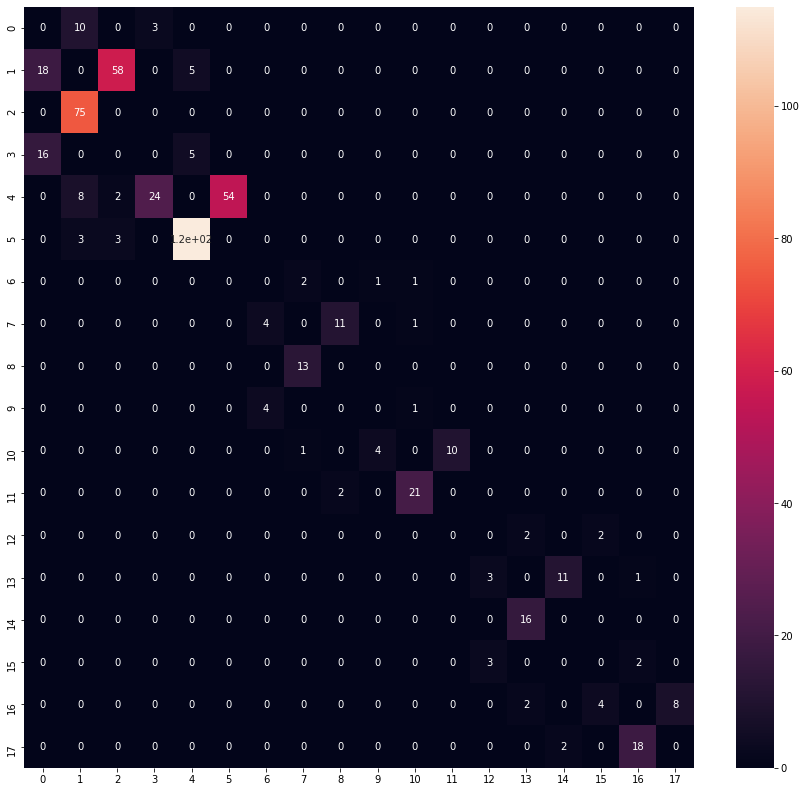

In [73]:
import seaborn as sns
mat = confusion_matrix(y_true=val_result['ans'], y_pred=val_result['ans_pred'])
np.fill_diagonal(mat, 0)
df_mat = pd.DataFrame(mat, range(18), range(18))
df_mat
plt.figure(figsize=(15,14))
sns.heatmap(df_mat, annot=True)

In [ ]:
model_all_rn.train()

Epoch 9:  74%|███████▍  | 93/126 [01:26<00:30,  1.08batch/s, accuracy=98.4, current_lr=1e-5, loss=0.0971, val_acc=None, val_loss=None]

In [44]:
model_all_rn.show_report()

100%|██████████| 23/23 [00:21<00:00,  1.08it/s]

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       410
           1       0.60      0.60      0.60       210
           2       0.58      0.56      0.57       160
           3       0.97      0.96      0.97       555
           4       0.75      0.84      0.79       450
           5       0.67      0.53      0.59       245
           6       0.90      0.99      0.94        82
           7       0.59      0.52      0.56        42
           8       0.60      0.56      0.58        32
           9       0.95      0.95      0.95       111
          10       0.77      0.81      0.79        90
          11       0.77      0.49      0.60        49
          12       0.91      1.00      0.95        82
          13       0.69      0.57      0.62        42
          14       0.63      0.69      0.66        32
          15       0.97      0.96      0.97       111
          16       0.74      0.84      0.79        90
          17       0.70    

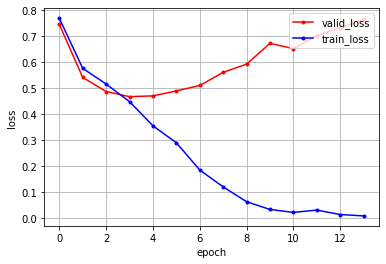

In [45]:
model_all_rn.show_history()

In [ ]:
os.rename('checkpoint_age.pt', '0406_10_resnext_checkpoint_age.pt')
os.rename('checkpoint_mask.pt', '0406_10_resnext_checkpoint_mask.pt')
os.rename('checkpoint_gender.pt', '0406_10_resnext_checkpoint_gender.pt')